Задание 5: Построение и оценка моделей прогнозирования
Подготовка данных

Необходимо взять не менее 100 значений и разбить их на 2 выборки (80/20). Первые 80 значений будут использоваться для обучения моделей.

Выбор моделей и параметров

Метод МНК (Квадратичная гипотеза)
Метод SVM
Метод Lasso
Метод PLS
Использовать не менее 2 параметров для прогнозирования целевого параметра. К параметрам добавить значения целевого параметра с отставанием на один шаг в прошлое.

Построение моделей и визуализация

Построить графики, используя построенные модели, и нанести значения из тренировочной и тестовой выборок.

Построить боксплоты для сопоставления тестовой выборки и прогноза.

Проверить адекватность полученных моделей с использованием критериев: Хи-квадрат, Фишера, Стьюдента.

Произвести выбор модели на основе полученных результатов.

## Data

In [77]:

import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

data1 = pd.read_csv('DataSet1_3.csv', sep = ',')


data1["Date"] = pd.to_datetime(data1["Date"])
data1["Date"] = data1["Date"].astype(np.int64) // 10**9


start_idx = 100
end_idx = 300

data = pd.DataFrame()

data['x'] = data1['Date'][start_idx:end_idx].to_numpy()-data1['Date'][start_idx]+1
data['y'] = data1['Close'][start_idx:end_idx].to_numpy()
data['p1'] = data1['Open'][start_idx:end_idx].to_numpy()
data['p2'] = data1['Close'][start_idx-1:end_idx-1].to_numpy()

n = round(0.8 * (end_idx - start_idx))

train = data[0:n]
test = data[n:]

x = data1['Date'][start_idx:end_idx].to_numpy()-data1['Date'][start_idx]
y = data1['Close'][start_idx:end_idx].to_numpy()


train_x = train.drop(['y'], axis = 1, inplace=False)
train_y = train['y']
test_x = test.drop(['y'], axis = 1, inplace=False)
test_y = test['y']
# train_x = x[0:n]
# train_y = y[0:n]

# test_x = x[n:]
# test_y = y[n:]


## МНК

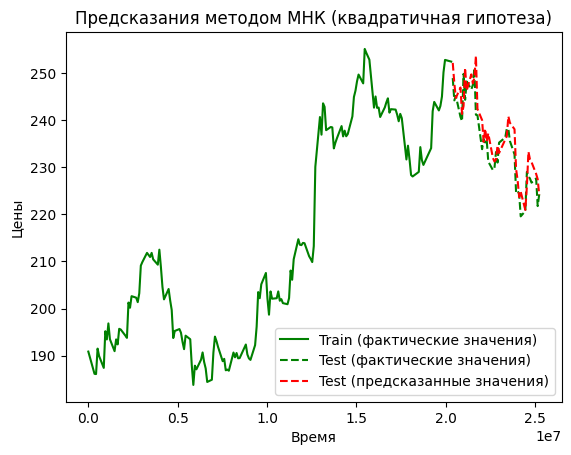

In [80]:
from scipy.optimize import curve_fit

def mapping_func(x, a, b, c, b1, b2):
    return a + b * x['x'] + c * x['x']**2 + b1 * x['p1'] + b2 * x['p2']
train_x = x[0:n]
train_y = y[0:n]

test_x = x[n:]
test_y = y[n:]
# Создаем DataFrame для обучения и тестирования
train_data = pd.DataFrame({'x': train_x, 'p1': train['p1'], 'p2': train['p2'], 'y': train_y})
test_data = pd.DataFrame({'x': test_x, 'p1': test['p1'], 'p2': test['p2'], 'y': test_y})

# Используем train_data вместо train_x, train_y в curve_fit
args, covar = curve_fit(mapping_func, train_data[['x', 'p1', 'p2']], train_data['y'])

a, b, c, b1, b2 = args[0], args[1], args[2], args[3], args[4]

# Применяем коэффициенты к данным
train_data['predicted'] = mapping_func(train_data, a, b, c, b1, b2)
test_data['predicted'] = mapping_func(test_data, a, b, c, b1, b2)

# Визуализация результатов
plt.plot(train_data['x'], train_data['y'], color='green', linestyle='solid', label='Train (фактические значения)')
plt.plot(test_data['x'], test_data['y'], color='green', linestyle='dashed', label='Test (фактические значения)')
plt.plot(test_data['x'], test_data['predicted'], color='red', linestyle='dashed', label='Test (предсказанные значения)')
plt.xlabel("Время")
plt.ylabel("Цены")
plt.title("Предсказания методом МНК (квадратичная гипотеза)")
plt.legend()
plt.show()

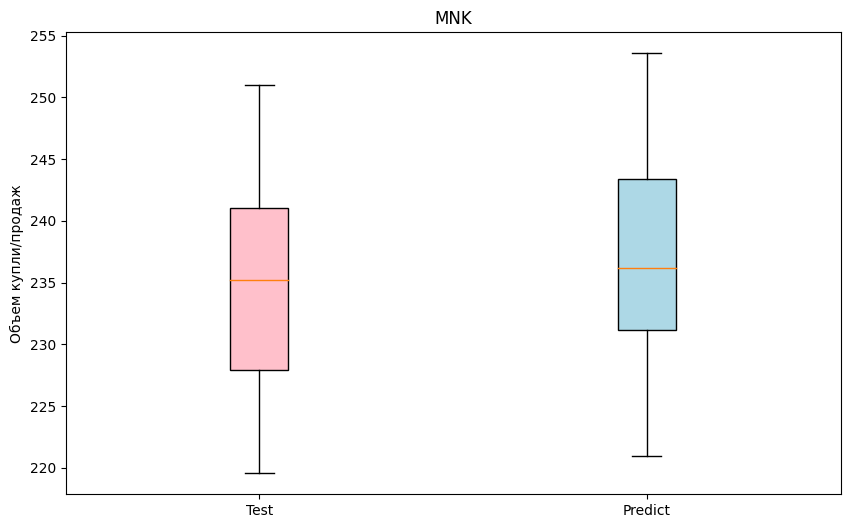

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['Test', 'Predict']
colors = ['pink', 'lightblue']

# Pass individual columns from test_data to boxplot
bplot = ax.boxplot([test['y'], test_data['predicted']], patch_artist=True, labels=labels)

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

ax.set(title="MNK", ylabel="Объем купли/продаж")

plt.show()


In [60]:
from scipy.stats import chisquare, f_oneway, ttest_ind

observed = test_data['y']  # Фактические значения из тестового набора
expected = test_data['predicted']  # Предсказанные значения

# Сравниваем суммы наблюдаемых и ожидаемых значений и нормализуем ожидаемые значения
observed_sum = observed.sum()
expected_sum = expected.sum()

scaling_factor = observed_sum / expected_sum
expected_scaled = expected * scaling_factor

# Проверка с помощью критерия Хи-квадрат
chi2, p = chisquare(f_obs=observed, f_exp=expected_scaled)
print(f"Критерий Хи-квадрат:\nХи-квадрат статистика: {chi2}")
print(f"p-значение: {p}")

# Проведение однофакторного дисперсионного анализа (ANOVA)
f_statistic, p_value = f_oneway(test_data['y'], test_data['predicted'])
print(f"\nКритерий Фишера\nF-статистика: {f_statistic}")
print(f"p-значение: {p_value}")

# Проведение двухвыборочного t-теста
t_statistic, p_value = ttest_ind(test_data['y'], test_data['predicted'])
print(f"\nКритерий Стьюдента:\nt-статистика: {t_statistic}")
print(f"p-значение: {p_value}")


Критерий Хи-квадрат:
Хи-квадрат статистика: 2.004140883601669
p-значение: 1.0

Критерий Фишера
F-статистика: 1.1691538207866148
p-значение: 0.28290692147361346

Критерий Стьюдента:
t-статистика: -1.0812741654116356
p-значение: 0.28290692147360996


## SVM

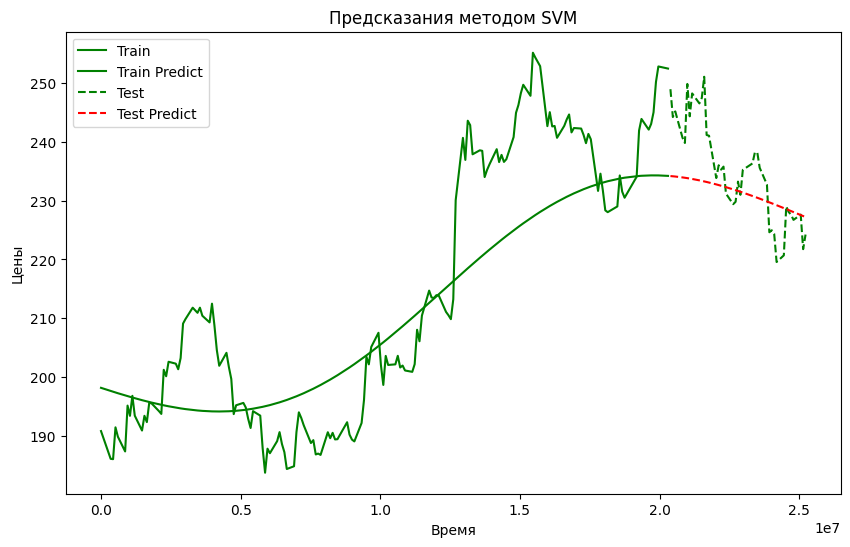

In [83]:
from sklearn.svm import SVR

train_x = train.drop(['y'], axis = 1, inplace=False)
train_y = train['y']
test_x = test.drop(['y'], axis = 1, inplace=False)
test_y = test['y']

model = SVR(kernel='rbf')
model.fit(train_x, train_y)

svr_res_tr = model.predict(train_x)
svr_res_ts = model.predict(test_x)

# Визуализация результатов
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(train['x'], train['y'], color='green', linestyle='solid')
plt.plot(train['x'], svr_res_tr, color='green', linestyle='solid')
plt.plot(test['x'], test['y'], color='green', linestyle='dashed')
plt.plot(test['x'], svr_res_ts, color='red', linestyle='dashed')

plt.title('SVR')
plt.xlabel("Время")
plt.ylabel("Цены")
plt.title("Предсказания методом SVM")
plt.legend(['Train','Train Predict', 'Test', 'Test Predict'])
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


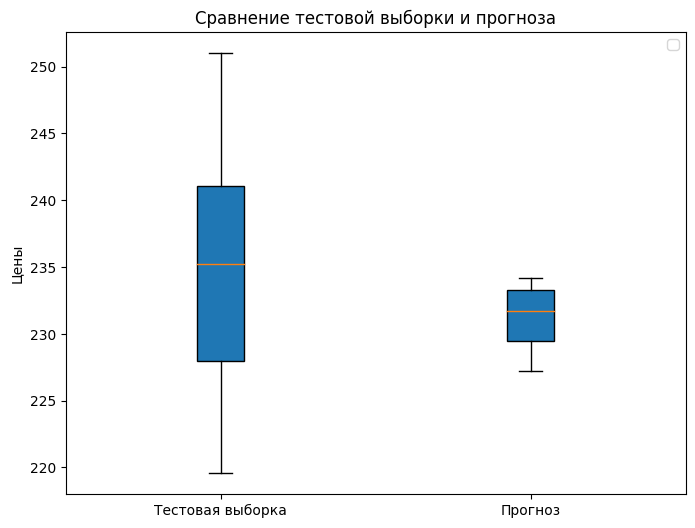

In [88]:
# Создание данных для Box-диаграммы
data_to_plot = [test['y'].values, svr_res_tr]

# Визуализация Box-диаграммы
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([test['y'], svr_res_ts], patch_artist=True, labels=['Тестовая выборка', 'Прогноз'])


ax.set(title="Сравнение тестовой выборки и прогноза", ylabel="Цены")
ax.legend()
plt.show()


In [100]:
from scipy.stats import chisquare, f_oneway, ttest_ind
from scipy import stats
# # Критерий Хи-квадрат
# chi2_stat, chi2_p_val = chisquare(test['y'], svr_res_ts)
chi2_stat, chi2_p_val = chisquare(test['y'], np.sum(test['y'])/np.sum(svr_res_ts)*svr_res_ts)
print(f"Хи-квадрат статистика: {chi2_stat}")
print(f"p-значение: {chi2_p_val}")
# Критерий Фишера (ANOVA)
anova_stat, anova_p_val = f_oneway(test['y'], svr_res_ts)
print(f"\nКритерий фишера:\nF-статистика: {anova_stat}")
print(f"p-значение: {anova_p_val}")

# Критерий Стьюдента (t-тест)
t_stat, t_p_val = ttest_ind(test['y'], svr_res_ts)
print(f"\nКритерий Стьюдента\nt-статистика: {t_stat}")
print(f"p-значение: {t_p_val}")

# Преобразуйте массивы в массивы NumPy и нормализуйте их

Хи-квадрат статистика: 7.9677941808164405
p-значение: 0.9999999783402838

Критерий фишера:
F-статистика: 6.618209420687902
p-значение: 0.011991951710499642

Критерий Стьюдента
t-статистика: 2.572588078314891
p-значение: 0.011991951710499608


## Lasso

C:\Users\opawk\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.356e+02, tolerance: 7.747e+00
  model = cd_fast.enet_coordinate_descent(


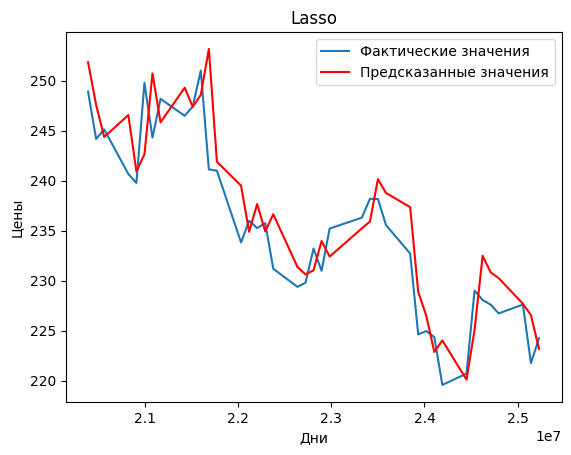

In [116]:

from sklearn.linear_model import Lasso

# Обучение модели Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(train[['x', 'p1', 'p2']], train['y'])
y_pred_lasso = lasso.predict(test[['x', 'p1', 'p2']])
# lasso.fit(train_x, train_y)

# y_pred_lasso = lasso.predict(train_x)
# y_tr_lasso = lasso.predict(train_y)
# Визуализация результатов
plt.plot(test_x, test_y, label='Фактические значения')
plt.plot(test_x, y_pred_lasso, color='red', label='Предсказанные значения')
plt.xlabel("Дни")
plt.ylabel("Цены")
plt.title("Lasso")
plt.legend()
plt.show()
# Визуализация результатов
# fig, ax = plt.subplots(figsize=(10,6))
# plt.plot(train['x'], train['y'], color='green', linestyle='solid')
# plt.plot(train['x'], svr_res_tr, color='green', linestyle='solid')
# plt.plot(test['x'], test['y'], color='green', linestyle='dashed')
# plt.plot(test['x'], svr_res_ts, color='red', linestyle='dashed')

# plt.title('SVR')
# plt.xlabel("Время")
# plt.ylabel("Цены")
# plt.title("Предсказания методом SVM")
# plt.legend(['Train','Train Predict', 'Test', 'Test Predict'])
# plt.show()



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


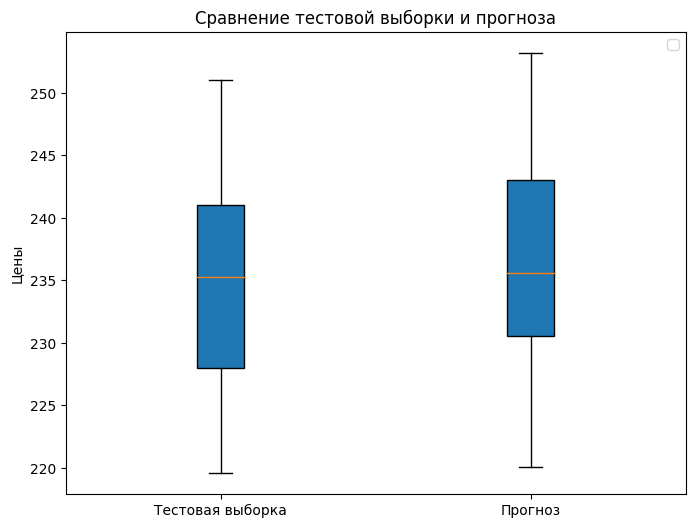

In [101]:
# Создание данных для Box-диаграммы
data_to_plot = [test['y'].values, y_pred_lasso]

# Визуализация Box-диаграммы
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([test['y'], y_pred_lasso], patch_artist=True, labels=['Тестовая выборка', 'Прогноз'])


ax.set(title="Сравнение тестовой выборки и прогноза", ylabel="Цены")
ax.legend()
plt.show()

In [99]:
from scipy.stats import chisquare, f_oneway, ttest_ind

# Критерий Хи-квадрат
chi2_stat, chi2_p_val = chisquare(test_y, np.sum(test_y)/np.sum(y_pred_lasso) * y_pred_lasso)
print(f"Хи-квадрат статистика: {chi2_stat}")
print(f"p-значение: {chi2_p_val}")

# Критерий Фишера (ANOVA)
anova_stat, anova_p_val = f_oneway(test_y, y_pred_lasso)
print(f"F-статистика: {anova_stat}")
print(f"p-значение: {anova_p_val}")

# Критерий Стьюдента (t-тест)
t_stat, t_p_val = ttest_ind(test_y, y_pred_lasso)
print(f"t-статистика: {t_stat}")
print(f"p-значение: {t_p_val}")



Хи-квадрат статистика: 2.0106255163834543
p-значение: 1.0
F-статистика: 0.5981987554959224
p-значение: 0.4416038382309596
t-статистика: -0.7734330969747301
p-значение: 0.44160383823096316


## PLS

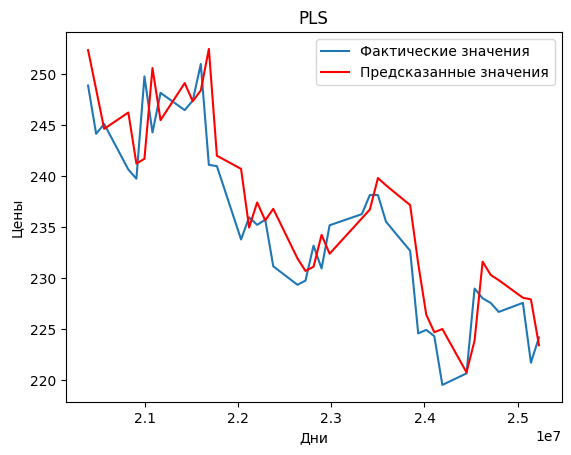

In [117]:
from sklearn.cross_decomposition import PLSRegression

# Обучение модели PLS
pls = PLSRegression(n_components=2)
pls.fit(train[['x', 'p1', 'p2']], train['y'])
y_pred_pls = pls.predict(test[['x', 'p1', 'p2']])

# Визуализация результатов
plt.plot(test_x, test_y, label='Фактические значения')
plt.plot(test_x, y_pred_pls, color='red', label='Предсказанные значения')
plt.xlabel("Дни")
plt.ylabel("Цены")
plt.title("PLS")
plt.legend()
# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


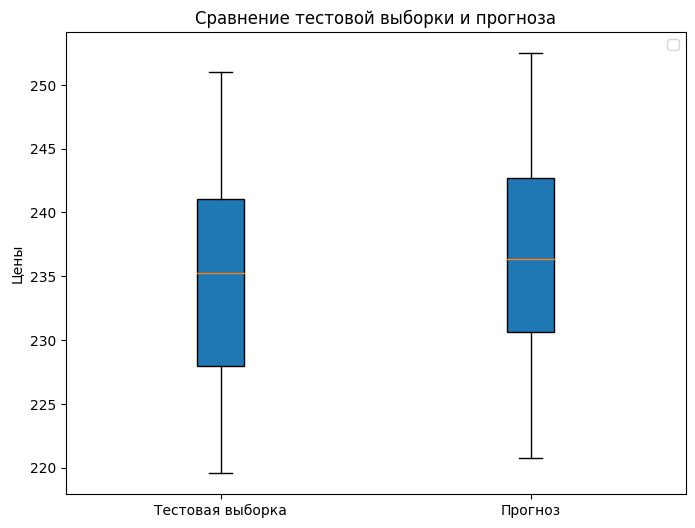

In [118]:
# Создание данных для Box-диаграммы
data_to_plot = [test['y'].values, y_pred_pls]

# Визуализация Box-диаграммы
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot([test['y'], y_pred_pls], patch_artist=True, labels=['Тестовая выборка', 'Прогноз'])


ax.set(title="Сравнение тестовой выборки и прогноза", ylabel="Цены")
ax.legend()
plt.show()

In [119]:
from scipy.stats import chisquare, f_oneway, ttest_ind

# Критерий Хи-квадрат
chi2_stat, chi2_p_val = chisquare(test_y, np.sum(test_y)/np.sum(y_pred_pls) * y_pred_pls)
print(f"Хи-квадрат статистика: {chi2_stat}")
print(f"p-значение: {chi2_p_val}")

# Критерий Фишера (ANOVA)
anova_stat, anova_p_val = f_oneway(test_y, y_pred_pls)
print(f"F-статистика: {anova_stat}")
print(f"p-значение: {anova_p_val}")

# Критерий Стьюдента (t-тест)
t_stat, t_p_val = ttest_ind(test_y, y_pred_pls)
print(f"t-статистика: {t_stat}")
print(f"p-значение: {t_p_val}")

Хи-квадрат статистика: 2.1914354529239235
p-значение: 1.0
F-статистика: 0.8158622936934489
p-значение: 0.3691738193997437
t-статистика: -0.9032509583130616
p-значение: 0.36917381939973926
